In [75]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import json

from lobio.simulator import Simulator
from lobio.accounting.pnl_counter import PnL_Counter
from lobio.model.avellaneda_stoikov_model import AvellanedaStoikov
from lobio.lob.limit_order import LimitOrder, PRICE_TICK, AMOUNT_TICK
from lobio.lob.order_book import TraderId, OrderBook
from lobio.utils.utils import group_diffs, group_orders

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
diffs_file = "../data/diffs_prepared.parquet"
init_lob_file = "../data/init_lob_prepared.npy"
orders_file = "../data/orders_prepared.parquet"

diffs = pl.read_parquet(diffs_file)
with open(init_lob_file, "rb") as file:
    init_lob = np.load(file)
orders = pl.read_parquet(orders_file)

In [61]:
diffs_grouped = group_diffs(diffs)
orders_prepared_np = orders.to_numpy()
orders_per_diff = group_orders(orders_prepared_np, len(diffs_grouped))

In [76]:
t0 = diffs_grouped[0][0]
T = diffs_grouped[-1][0] + 100

pnl_counter = PnL_Counter()
alpha = AvellanedaStoikov(T=T, t_start=t0, q0=0, k=2, sigma=3, gamma=0.5, q_max=1)
simulator = Simulator(diffs_grouped, orders_per_diff, init_lob, alpha, pnl_counter, T)

In [77]:
run_data = simulator.run_maker(market_latency=10, local_latency=10)

100%|██████████| 23209/23209 [00:30<00:00, 749.61it/s] 


agent asset amount - 34567173, agent money amount - 22091824088


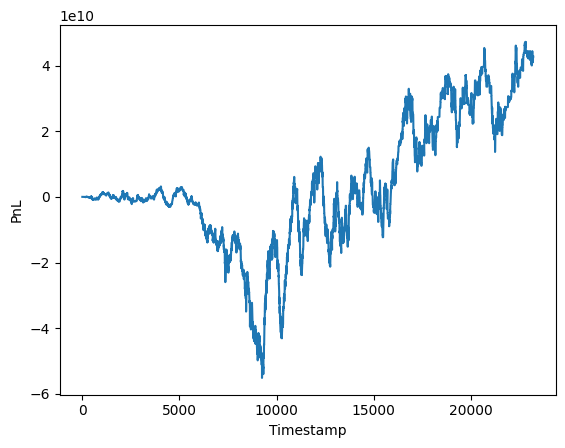

In [78]:
print(f"agent asset amount - {run_data[1]}, agent money amount - {run_data[2]}")
plt.plot(run_data[0])
plt.xlabel("Timestamp")
plt.ylabel("PnL")
plt.show()

In [79]:
run_data[1]  * simulator.order_book.ask_price() + run_data[2] 

12699602521838

In [80]:
run_data[1], simulator.order_book.ask_price(), run_data[2]

(34567173, 366750, 22091824088)

In [73]:
alpha.bid_ask_limit_orders(simulator.order_book, T-200, 2)

([LimitOrder(base=366749, quote=1, side=<Side.BUY: -1>, trader_id=<TraderId.MM: 1>)],
 [LimitOrder(base=366750, quote=1, side=<Side.SELL: 1>, trader_id=<TraderId.MM: 1>)])

In [74]:
simulator.order_book.bid_price(), simulator.order_book.ask_price()

(366749, 366750)